    Comparison of algorithm
    

In [1]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import keras
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, DepthwiseConv2D, BatchNormalization, Activation, Add, GlobalAvgPool2D, MaxPool2D, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\Hasan\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "c:\Users\Hasan\AppData\Local\Programs\Python\Python311\Lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
    app.start()
  File "c:\Users\Hasan\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\kernelapp.py", 

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\Hasan\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "c:\Users\Hasan\AppData\Local\Programs\Python\Python311\Lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
    app.start()
  File "c:\Users\Hasan\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\kernelapp.py", 

AttributeError: _ARRAY_API not found

In [2]:
# Data Generators
train = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, validation_split=0.2)
train_data = train.flow_from_directory(directory='DATASET/TRAIN', target_size=(224,224), batch_size=32, class_mode='categorical')
test = ImageDataGenerator(rescale=1./255)
test_data = test.flow_from_directory(directory='DATASET/TEST', target_size=(224,224), batch_size=32, class_mode='categorical')

Found 2000 images belonging to 4 classes.
Found 2000 images belonging to 4 classes.


In [3]:
steps_per_epoch = max(1, train_data.samples // 512)
validation_steps = max(1, test_data.samples // 512)
print(f"Steps per epoch: {steps_per_epoch}, Validation steps: {validation_steps}")

Steps per epoch: 3, Validation steps: 3


In [4]:
# MobileNet
def mobilenet_block(x, f, s=1):
    x = DepthwiseConv2D(3, strides=s, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(f, 1, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def mobilenet(input_shape, n_classes):
    input = Input(input_shape)
    x = Conv2D(32, 3, strides=2, padding='same')(input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = mobilenet_block(x, 64)
    x = mobilenet_block(x, 128, s=2)
    x = mobilenet_block(x, 128)
    x = mobilenet_block(x, 256, s=2)
    x = mobilenet_block(x, 256)
    x = mobilenet_block(x, 512, s=2)
    for _ in range(5):
        x = mobilenet_block(x, 512)
    x = mobilenet_block(x, 1024, s=2)
    x = mobilenet_block(x, 1024)
    x = GlobalAvgPool2D()(x)
    output = Dense(n_classes, activation='softmax')(x)
    model = Model(input, output)
    model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision()])
    return model

In [5]:
# ResNet-50
def resnet_block(x, filters, kernel_size=3, stride=1, conv_shortcut=True):
    shortcut = x
    if conv_shortcut:
        shortcut = Conv2D(filters, 1, strides=stride, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)
    x = Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, kernel_size, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Add()([shortcut, x])
    x = Activation('relu')(x)
    return x

def resnet50(input_shape, n_classes):
    input = Input(input_shape)
    x = Conv2D(64, 7, strides=2, padding='same')(input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPool2D(3, strides=2, padding='same')(x)
    x = resnet_block(x, 64, conv_shortcut=True)
    x = resnet_block(x, 64)
    x = resnet_block(x, 64)
    x = resnet_block(x, 128, stride=2, conv_shortcut=True)
    x = resnet_block(x, 128)
    x = resnet_block(x, 128)
    x = resnet_block(x, 128)
    x = resnet_block(x, 256, stride=2, conv_shortcut=True)
    x = resnet_block(x, 256)
    x = resnet_block(x, 256)
    x = resnet_block(x, 256)
    x = resnet_block(x, 256)
    x = resnet_block(x, 256)
    x = resnet_block(x, 512, stride=2, conv_shortcut=True)
    x = resnet_block(x, 512)
    x = resnet_block(x, 512)
    x = GlobalAvgPool2D()(x)
    output = Dense(n_classes, activation='softmax')(x)
    model = Model(input, output)
    model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision()])
    return model

In [6]:
# VGG-16
def vgg16(input_shape, n_classes):
    input = Input(input_shape)
    x = Conv2D(64, 3, padding='same', activation='relu')(input)
    x = Conv2D(64, 3, padding='same', activation='relu')(x)
    x = MaxPool2D(2, strides=2)(x)
    x = Conv2D(128, 3, padding='same', activation='relu')(x)
    x = Conv2D(128, 3, padding='same', activation='relu')(x)
    x = MaxPool2D(2, strides=2)(x)
    x = Conv2D(256, 3, padding='same', activation='relu')(x)
    x = Conv2D(256, 3, padding='same', activation='relu')(x)
    x = Conv2D(256, 3, padding='same', activation='relu')(x)
    x = MaxPool2D(2, strides=2)(x)
    x = Conv2D(512, 3, padding='same', activation='relu')(x)
    x = Conv2D(512, 3, padding='same', activation='relu')(x)
    x = Conv2D(512, 3, padding='same', activation='relu')(x)
    x = MaxPool2D(2, strides=2)(x)
    x = Conv2D(512, 3, padding='same', activation='relu')(x)
    x = Conv2D(512, 3, padding='same', activation='relu')(x)
    x = Conv2D(512, 3, padding='same', activation='relu')(x)
    x = MaxPool2D(2, strides=2)(x)
    x = Flatten()(x)
    x = Dense(4096, activation='relu')(x)
    x = Dense(4096, activation='relu')(x)
    output = Dense(n_classes, activation='softmax')(x)
    model = Model(input, output)
    model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision()])
    return model

In [7]:
# Manual Net (Custom CNN)
def manual_net(input_shape, n_classes):
    input = Input(input_shape)
    x = Conv2D(32, 3, padding='same', activation='relu')(input)
    x = BatchNormalization()(x)
    x = MaxPool2D(2, strides=2)(x)
    x = Conv2D(64, 3, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(2, strides=2)(x)
    x = Conv2D(128, 3, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(2, strides=2)(x)
    x = Conv2D(256, 3, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(2, strides=2)(x)
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    output = Dense(n_classes, activation='softmax')(x)
    model = Model(input, output)
    model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision()])
    return model

In [8]:
# Hybrid (MobileNet + ResNet)
def hybrid_mobilenet_resnet(input_shape, n_classes):
    input = Input(input_shape)
    x = Conv2D(32, 3, strides=2, padding='same')(input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = mobilenet_block(x, 64)
    x = mobilenet_block(x, 128, s=2)
    x = mobilenet_block(x, 128)
    x = resnet_block(x, 256, stride=2, conv_shortcut=True)
    x = resnet_block(x, 256)
    x = resnet_block(x, 512, stride=2, conv_shortcut=True)
    x = resnet_block(x, 512)
    x = resnet_block(x, 512)
    x = mobilenet_block(x, 1024, s=2)
    x = mobilenet_block(x, 1024)
    x = GlobalAvgPool2D()(x)
    output = Dense(n_classes, activation='softmax')(x)
    model = Model(input, output)
    model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision()])
    return model


In [9]:
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Concatenate, Dropout
from tensorflow.keras import backend as K

def hybrid_resnet_vgg(input_shape, n_classes):
    input_layer = Input(shape=input_shape)

    # ResNet base
    resnet_base = ResNet50(weights='imagenet', include_top=False, input_tensor=input_layer)
    for layer in resnet_base.layers:
        layer.trainable = False
    resnet_output = GlobalAveragePooling2D()(resnet_base.output)

    # VGG base
    vgg_base = VGG16(weights='imagenet', include_top=False, input_tensor=input_layer)
    for layer in vgg_base.layers:
        layer.trainable = False
    vgg_output = GlobalAveragePooling2D()(vgg_base.output)

    # Concatenate both outputs
    merged = Concatenate()([resnet_output, vgg_output])
    merged = Dense(512, activation='relu')(merged)
    merged = Dropout(0.5)(merged)
    output = Dense(n_classes, activation='softmax')(merged)

    model = Model(inputs=input_layer, outputs=output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [10]:
input_shape = (224, 224, 3)
n_classes = 4
epochs = 5

In [ ]:
# Train MobileNet
K.clear_session()
mobilenet_model = mobilenet(input_shape, n_classes)
mobilenet_model.summary()
mobilenet_history = mobilenet_model.fit(
    train_data, steps_per_epoch=steps_per_epoch,
    epochs=10,
    validation_data=test_data, validation_steps=validation_steps
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 112, 112, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d                │ (None, 112, 112, 32)   │           320 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_1              │ (None, 56, 56, 64)     │           640 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_2              │ (None, 56, 56, 128)    │         1,280 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 56, 56, 128)    │        16,512 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 3,243,908 (12.37 MB)

 Trainable params: 3,222,020 (12.29 MB)

 Non-trainable params: 21,888 (85.50 KB)

Epoch 1/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 40s 9s/step - accuracy: 0.2292 - loss: 1.5175 - precision: 0.2847 - val_accuracy: 0.2604 - val_loss: 1.3817 - val_precision: 0.0000e+00
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - accuracy: 0.2357 - loss: 1.4933 - precision: 0.2368 - val_accuracy: 0.2917 - val_loss: 1.3840 - val_precision: 0.0000e+00
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 4s/step - accuracy: 0.3229 - loss: 1.3855 - precision: 0.3734 - val_accuracy: 0.2396 - val_loss: 1.3854 - val_precision: 0.0000e+00
Epoch 4/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 4s/step - accuracy: 0.4167 - loss: 1.3724 - precision: 0.5417 - val_accuracy: 0.2292 - val_loss: 1.3831 - val_precision: 0.0000e+00
Epoch 5/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 4s/step - accuracy: 0.5560 - loss: 0.9791 - precision: 0.7478 - val_accuracy: 0.2292 - val_loss: 1.3833 - val_precision: 0.0000e+00


In [12]:
# Build and summarize the model
K.clear_session()
resnet_model = resnet50(input_shape, n_classes)
resnet_model.summary()

resnet_history = resnet_model.fit(
    train_data,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=test_data,
    validation_steps=validation_steps
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 112, 112,  │      9,472 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 112, 112,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 56, 56,    │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 56, 56,    │     36,928 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 56, 56,    │      4,160 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 56, 56,    │     36,928 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 56, 56,    │          0 │ add[0][0]         │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 56, 56,    │     36,928 │ activation_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 56, 56,    │          0 │ batch_normalizat

 Total params: 22,240,068 (84.84 MB)

 Trainable params: 22,217,284 (84.75 MB)

 Non-trainable params: 22,784 (89.00 KB)

Epoch 1/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 60s 10s/step - accuracy: 0.3385 - loss: 2.5223 - precision: 0.2841 - val_accuracy: 0.3646 - val_loss: 1.3653 - val_precision: 0.0000e+00
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 16s 6s/step - accuracy: 0.3307 - loss: 2.3672 - precision: 0.3329 - val_accuracy: 0.2812 - val_loss: 34.9756 - val_precision: 0.3506
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 16s 6s/step - accuracy: 0.3893 - loss: 1.7679 - precision: 0.3659 - val_accuracy: 0.2604 - val_loss: 2130.3132 - val_precision: 0.2604
Epoch 4/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 17s 6s/step - accuracy: 0.6380 - loss: 0.8637 - precision: 0.7972 - val_accuracy: 0.2917 - val_loss: 9139.2412 - val_precision: 0.2917
Epoch 5/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 17s 6s/step - accuracy: 0.6042 - loss: 0.8006 - precision: 0.6672 - val_accuracy: 0.2708 - val_loss: 14191.7998 - val_precision: 0.2708


In [13]:
#Train VGG-16
K.clear_session()
vgg_model = vgg16(input_shape, n_classes)
vgg_model.summary()
vgg_history = vgg_model.fit(
    train_data, steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=test_data, validation_steps=validation_steps
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │        16,388 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,276,932 (512.23 MB)

 Trainable params: 134,276,932 (512.23 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 539s 226s/step - accuracy: 0.1953 - loss: 1.8512 - precision: 0.2344 - val_accuracy: 0.2812 - val_loss: 1.3923 - val_precision: 0.0000e+00
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 470s 190s/step - accuracy: 0.2201 - loss: 1.4307 - precision: 0.0000e+00 - val_accuracy: 0.2708 - val_loss: 1.3855 - val_precision: 0.0000e+00
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 505s 220s/step - accuracy: 0.2591 - loss: 1.3868 - precision: 0.0000e+00 - val_accuracy: 0.2604 - val_loss: 1.3892 - val_precision: 0.0000e+00
Epoch 4/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 364s 152s/step - accuracy: 0.2526 - loss: 1.3848 - precision: 0.0000e+00 - val_accuracy: 0.1875 - val_loss: 1.3890 - val_precision: 0.0000e+00
Epoch 5/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 308s 122s/step - accuracy: 0.2969 - loss: 1.3796 - precision: 0.0000e+00 - val_accuracy: 0.2917 - val_loss: 1.3841 - val_precision: 0.0000e+00


In [ ]:
# Train Manual Net
K.clear_session()
manualnet_model = manual_net(input_shape, n_classes)
manualnet_model.summary()
manualnet_history = manualnet_model.fit(
    train_data, steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=test_data, validation_steps=validation_steps
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    25,690,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,147,140 (99.74 MB)

 Trainable params: 26,146,180 (99.74 MB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 19s 5s/step - accuracy: 0.3307 - loss: 18.8735 - precision: 0.3443 - val_accuracy: 0.3125 - val_loss: 2.0257 - val_precision: 0.3846
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.4563 - loss: 9.3984 - precision: 0.4563 - val_accuracy: 0.3021 - val_loss: 2.1860 - val_precision: 0.3333
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.6693 - loss: 4.4115 - precision: 0.6693 - val_accuracy: 0.3750 - val_loss: 3.8794 - val_precision: 0.3750
Epoch 4/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - accuracy: 0.8268 - loss: 2.0513 - precision: 0.8268 - val_accuracy: 0.2604 - val_loss: 5.6148 - val_precision: 0.2604
Epoch 5/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - accuracy: 0.7227 - loss: 2.8568 - precision: 0.7227 - val_accuracy: 0.4062 - val_loss: 5.1619 - val_precision: 0.4149


In [ ]:
# Train Hybrid ResNet + VGG16
K.clear_session()
hybrid_model2 = hybrid_resnet_vgg(input_shape=(224, 224, 3), n_classes=4)
hybrid_model.summary()

hybrid_history2 = hybrid_model.fit(
    train_data,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=test_data,
    validation_steps=validation_steps
)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 42,242,254 (161.14 MB)

 Trainable params: 1,313,284 (5.01 MB)

 Non-trainable params: 38,302,400 (146.11 MB)

 Optimizer params: 2,626,570 (10.02 MB)

Epoch 1/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 31s 12s/step - accuracy: 0.2917 - loss: 2.1787 - val_accuracy: 0.4062 - val_loss: 1.8634
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 24s 10s/step - accuracy: 0.3294 - loss: 1.6591 - val_accuracy: 0.3125 - val_loss: 1.8798
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 24s 10s/step - accuracy: 0.3724 - loss: 1.7969 - val_accuracy: 0.3438 - val_loss: 1.2741
Epoch 4/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 22s 9s/step - accuracy: 0.3477 - loss: 1.3993 - val_accuracy: 0.2812 - val_loss: 1.4702
Epoch 5/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 22s 9s/step - accuracy: 0.2552 - loss: 1.7408 - val_accuracy: 0.5833 - val_loss: 1.1623


In [ ]:
# Comparison Visualization
plt.figure(figsize=(20, 8))

<Figure size 2000x800 with 0 Axes>

<Figure size 2000x800 with 0 Axes>

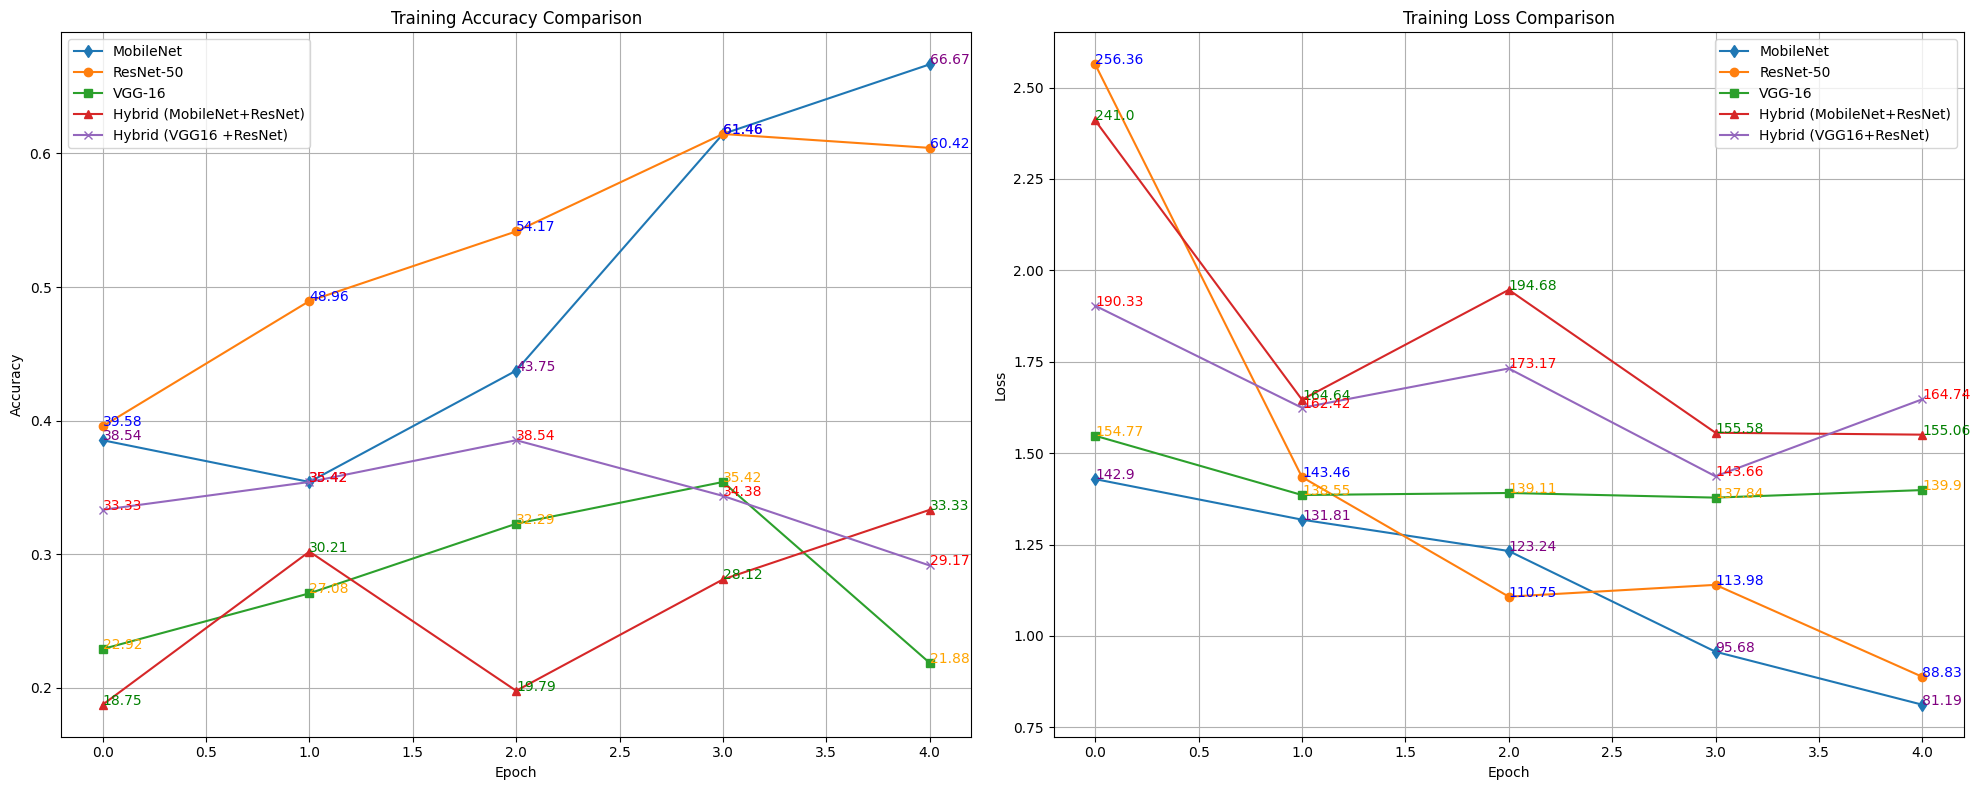

In [ ]:
# Comparison Visualization
plt.figure(figsize=(20, 8))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(mobilenet_history.history['accuracy'], label='MobileNet', marker='d')
plt.plot(resnet_history.history['accuracy'], label='ResNet-50', marker='o')
plt.plot(vgg_history.history['accuracy'], label='VGG-16', marker='s')
plt.plot(hybrid_history.history['accuracy'], label='Hybrid (MobileNet+ResNet)', marker='^')
plt.plot(hybrid_history2.history['accuracy'], label='Hybrid (VGG16 + ResNet)', marker='x')
for i in range(epochs):
    plt.annotate(np.round(mobilenet_history.history['accuracy'][i]*100, 2), xy=(i, mobilenet_history.history['accuracy'][i]), color='purple')
    plt.annotate(np.round(resnet_history.history['accuracy'][i]*100, 2), xy=(i, resnet_history.history['accuracy'][i]), color='blue')
    plt.annotate(np.round(vgg_history.history['accuracy'][i]*100, 2), xy=(i, vgg_history.history['accuracy'][i]), color='orange')
    plt.annotate(np.round(hybrid_history.history['accuracy'][i]*100, 2), xy=(i, hybrid_history.history['accuracy'][i]), color='green')
    plt.annotate(np.round(hybrid_history2.history['accuracy'][i]*100, 2), xy=(i, hybrid_history2.history['accuracy'][i]), color='red')
plt.title('Training Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(mobilenet_history.history['loss'], label='MobileNet', marker='d')
plt.plot(resnet_history.history['loss'], label='ResNet-50', marker='o')
plt.plot(vgg_history.history['loss'], label='VGG-16', marker='s')
plt.plot(hybrid_history.history['loss'], label='Hybrid (MobileNet+ResNet)', marker='^')
plt.plot(hybrid_history2.history['loss'], label='Hybrid (VGG16+ResNet)', marker='x')
for i in range(epochs):
    plt.annotate(np.round(mobilenet_history.history['loss'][i]*100, 2), xy=(i, mobilenet_history.history['loss'][i]), color='purple')
    plt.annotate(np.round(resnet_history.history['loss'][i]*100, 2), xy=(i, resnet_history.history['loss'][i]), color='blue')
    plt.annotate(np.round(vgg_history.history['loss'][i]*100, 2), xy=(i, vgg_history.history['loss'][i]), color='orange')
    plt.annotate(np.round(hybrid_history.history['loss'][i]*100, 2), xy=(i, hybrid_history.history['loss'][i]), color='green')
plt.title('Training Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('model_comparison.png')

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, f1_score, recall_score
import numpy as np

# Predict classes on test data
y_pred_probs = mobilenet_model.predict(test_data, steps=validation_steps)
y_pred = np.argmax(y_pred_probs, axis=1)

# Get true labels
y_true = np.concatenate([np.argmax(y, axis=1) for _, y in test_data], axis=0)

# Ensure the number of predictions and labels match
y_pred = y_pred[:len(y_true)]

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Recall: {recall:.4f}")


NameError: name 'mobilenet_model' is not defined